## Регрессия
Задача: предсказать зарплату игрока НХЛ по его статистике с использованием модели линейной регрессии.

Будем использовать MAE, так как она очень наглядная, будет легко понять, насколько долларов ошибается модель. В качестве дополнительной метрики будем использовать R^2, чтобы смотреть насколько отличается предсказание от среднего.

### Baseline

Скачаем датасет с kaggle

In [632]:
import kagglehub
import pandas as pd
import numpy as np
from kagglehub import KaggleDatasetAdapter


path = kagglehub.dataset_download(
    "camnugent/predict-nhl-player-salaries/versions/2"
)

df1 = pd.read_csv(path + "/train.csv")
df2 = pd.read_csv(path + "/test.csv")
salary = pd.read_csv(path + "/test_salaries.csv")

df2['Salary'] = salary['Salary'].values
df2 = df2[df1.columns]
df = pd.concat([df1, df2], ignore_index=True)
df.head()

,Salary,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,925000.00,97-01-30,Sainte-Marie,QC,CAN,CAN,74,190,2015.00,1.00,...,1.00,0.00,-0.20,-0.20,40.03,1,0.00,175.70,-0.40,-0.38
1,2250000.00,93-12-21,Ottawa,ON,CAN,CAN,74,207,2012.00,1.00,...,98.00,-0.20,3.40,3.20,2850.59,290,13.30,112.50,14.10,0.18
2,8000000.00,88-04-16,St. Paul,MN,USA,USA,72,218,2006.00,1.00,...,70.00,3.70,1.30,5.00,2486.75,102,6.60,114.80,36.80,0.57
3,3500000.00,92-01-07,Ottawa,ON,CAN,CAN,77,220,2010.00,1.00,...,22.00,0.00,0.40,0.50,1074.41,130,17.50,105.10,5.90,0.20
4,1750000.00,94-03-29,Toronto,ON,CAN,CAN,76,217,2012.00,1.00,...,68.00,-0.10,1.40,1.30,3459.09,425,8.30,99.50,21.80,0.27


Сделаем минимальные телодвижения, чтобы регрессор заработал: закодируем все строковые данные, уберем NaN

In [633]:
df['Born'] = pd.to_datetime(df['Born'], format='%y-%m-%d')
df_clean = df.fillna(0)
for col in df_clean.select_dtypes(include=['object']).columns:
    df_clean[col] = df_clean[col].astype('category').cat.codes
df_clean = df_clean.drop("Born", axis=1)

In [634]:
from sklearn.model_selection import train_test_split

TARGET_NAME = "Salary"
X = df_clean.drop(TARGET_NAME, axis=1)
y = df_clean[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [635]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
base_mean_error = mean_absolute_error(y_test, [y_train.mean()]*len(y_test))

print(f"--- Baseline LinearRegreesion ---")
print(f"MAE (Ошибка в долларах): {mae:.3f}")
print(f"R2 Score: {r2:.3f}")

--- Baseline LinearRegreesion ---
MAE (Ошибка в долларах): 1381895.059
R2 Score: 0.324


Базовый линейный регрессор выдал результаты хуже, чем KNN. В целом может и логично, потому что похожие игроки в НХЛ по качеству должны зарабатывать примерно одинаково, что буквально есть KNN. Попробуем оптимизировать.

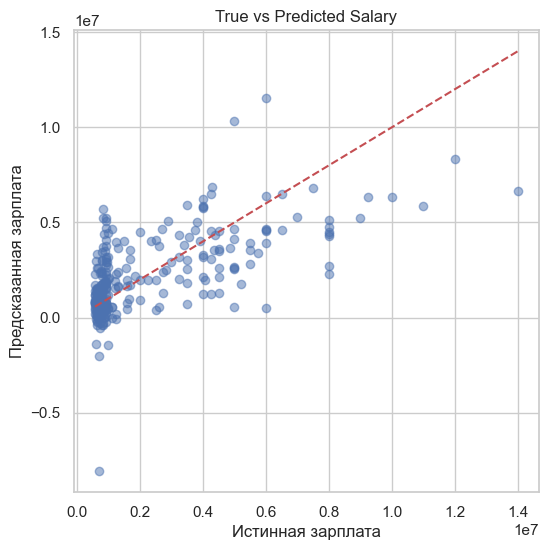

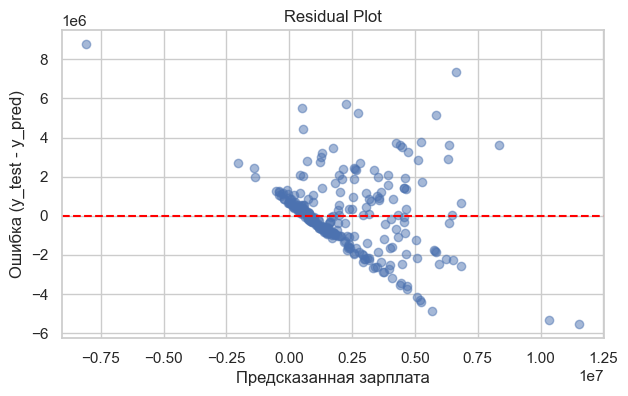

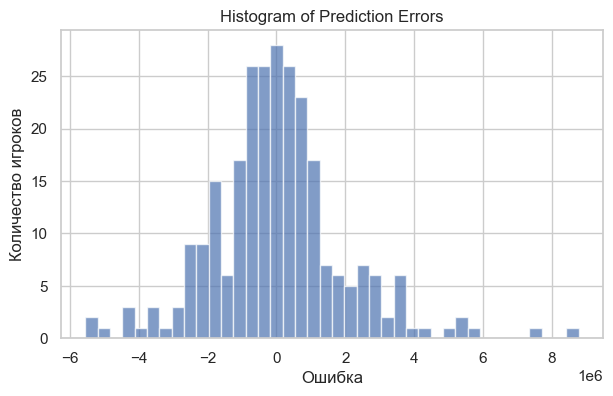

In [636]:
from matplotlib import pyplot as plt

def true_vs_predicted(y_test, y_pred):
    plt.figure(figsize=(6,6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Истинная зарплата")
    plt.ylabel("Предсказанная зарплата")
    plt.title("True vs Predicted Salary")
    plt.grid(True)
    plt.show()

def resudial(y_test, y_pred):
    residuals = y_test - y_pred
    plt.figure(figsize=(7,4))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Предсказанная зарплата")
    plt.ylabel("Ошибка (y_test - y_pred)")
    plt.title("Residual Plot")
    plt.grid(True)
    plt.show()
def histogramm_error(y_test, y_pred):
    plt.figure(figsize=(7,4))
    residuals = y_test - y_pred
    plt.hist(residuals, bins=40, alpha=0.7)
    plt.title("Histogram of Prediction Errors")
    plt.xlabel("Ошибка")
    plt.ylabel("Количество игроков")
    plt.grid(True)
    plt.show()
true_vs_predicted(y_test, y_pred)
resudial(y_test, y_pred)
histogramm_error(y_test, y_pred)

По графикам видно, что регрессору удалось даже предсказать отрицательную зарплату! Это круто, как же плохо надо играть?

### Improved Linear Regression

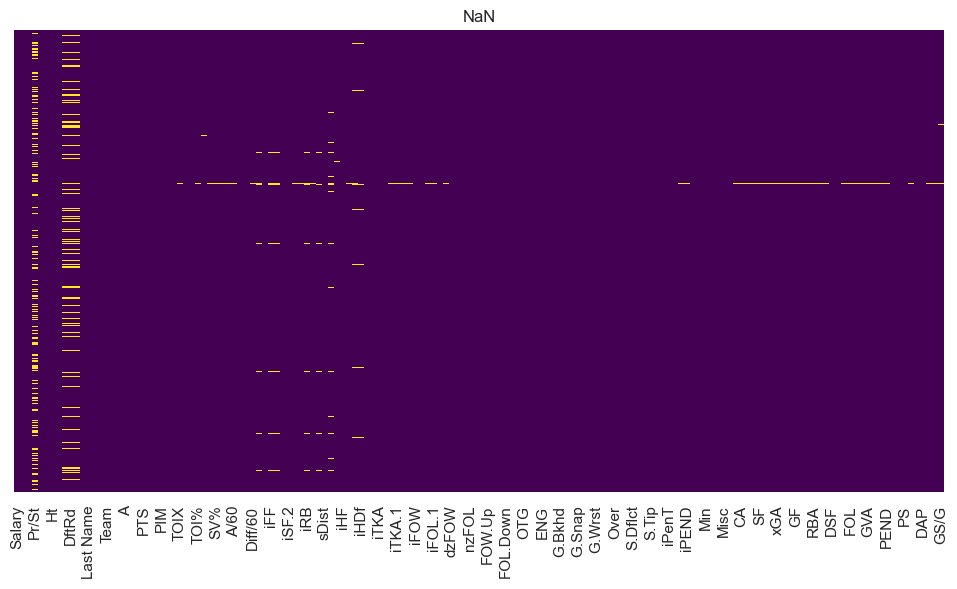

In [637]:
import kagglehub
from matplotlib import pyplot as plt
import pandas as pd


path = kagglehub.dataset_download(
    "camnugent/predict-nhl-player-salaries/versions/2"
)

df1 = pd.read_csv(path + "/train.csv")
df2 = pd.read_csv(path + "/test.csv")
salary = pd.read_csv(path + "/test_salaries.csv")
df2['Salary'] = salary['Salary'].values
df2 = df2[df1.columns]
df = pd.concat([df1, df2], ignore_index=True)

nulls = df.isna().sum().sort_values(ascending=False)
null_pct = (nulls / len(df)).mul(100).round(2)

plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("NaN")
plt.show()

In [638]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Salary,874.00,2325288.71,2298252.56,575000.00,742500.00,925000.00,3700000.00,14000000.00
Ht,874.00,73.08,2.11,66.00,72.00,73.00,75.00,81.00
Wt,874.00,200.84,15.06,157.00,190.00,200.00,210.00,265.00
DftYr,749.00,2008.71,4.38,1990.00,2006.00,2010.00,2012.00,2016.00
DftRd,749.00,2.74,1.99,1.00,1.00,2.00,4.00,9.00
...,...,...,...,...,...,...,...,...
Grit,874.00,126.78,101.61,0.00,41.00,114.00,190.00,622.00
DAP,874.00,9.22,7.82,0.00,4.60,7.60,12.00,61.00
Pace,873.00,108.94,8.90,75.00,104.70,109.20,113.90,175.70
GS,873.00,21.87,21.99,-4.30,2.60,15.70,35.40,104.70


In [639]:
import pandas as pd
import numpy as np

num_cols = df.select_dtypes(include=["int64", "float64"]).columns

corr_matrix = df[num_cols].corr()

corr_pairs = corr_matrix.unstack().reset_index()
corr_pairs.columns = ['feature_1', 'feature_2', 'correlation']

corr_pairs = corr_pairs[corr_pairs['feature_1'] < corr_pairs['feature_2']]

corr_pairs = corr_pairs.reindex(
    corr_pairs['correlation'].abs().sort_values(ascending=False).index
)

top40 = corr_pairs.head(40)

display(top40)
upper = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
upper_corr = corr_matrix.where(upper)


,feature_1,feature_2,correlation
4931,iSF.1,iSF.2,1.00
8267,iFOL,iFOL.1,1.00
8122,iFOW,iFOW.1,1.00
6381,iHF,iHF.1,1.00
2321,TOI,TOIX,1.00
7398,iBLK,iBLK.1,1.00
4787,iSF,iSF.2,1.00
4786,iSF,iSF.1,1.00
7108,iGVA,iGVA.1,1.00
7253,iTKA,iTKA.1,1.00


In [640]:
BARIER = 0.9998

to_drop = [col for col in upper_corr.columns if any(upper_corr[col] > BARIER)]
df_clean = df.drop(columns=to_drop)
df_clean.head()

,Salary,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,925000.00,97-01-30,Sainte-Marie,QC,CAN,CAN,74,190,2015.00,1.00,...,1.00,0.00,-0.20,-0.20,40.03,1,0.00,175.70,-0.40,-0.38
1,2250000.00,93-12-21,Ottawa,ON,CAN,CAN,74,207,2012.00,1.00,...,98.00,-0.20,3.40,3.20,2850.59,290,13.30,112.50,14.10,0.18
2,8000000.00,88-04-16,St. Paul,MN,USA,USA,72,218,2006.00,1.00,...,70.00,3.70,1.30,5.00,2486.75,102,6.60,114.80,36.80,0.57
3,3500000.00,92-01-07,Ottawa,ON,CAN,CAN,77,220,2010.00,1.00,...,22.00,0.00,0.40,0.50,1074.41,130,17.50,105.10,5.90,0.20
4,1750000.00,94-03-29,Toronto,ON,CAN,CAN,76,217,2012.00,1.00,...,68.00,-0.10,1.40,1.30,3459.09,425,8.30,99.50,21.80,0.27


Тут я пытался добавить дополнительные признаки, но они плохо работали. Поэтому я их закомментировал.

In [641]:
df_features = df_clean.copy()

df_features['Born'] = pd.to_datetime(df_features['Born'], format='%y-%m-%d')
reference_date = pd.Timestamp('2016-10-01')
df_features['Age'] = (reference_date - df_features['Born']).dt.days / 365.25

df_features["Age_bucket"] = pd.cut(
    df_features["Age"],
    bins=[0, 20, 25, 30, 35, 40, 45],
    labels=["<20", "20-34", "25-29", "30-34", "35-39", "40+"],
)
df_features["PTS_bucket"] = pd.cut(
    df_features["PTS"],
    bins=[-1, 20, 40, 60, 80, 100, 120, 140, 160],
    labels=["<20", "20-39", "40-59", "60-79", "80-99", "100-119", "120-139", "140-159"],
)
# df_features['G_per_GP'] = np.where(
#     df_features['GP'] != 0,
#     df_features['G'] / df_features['GP'],
#     0
# )
# df_features['A_per_GP'] = np.where(
#     df_features['GP'] != 0,
#     df_features['A'] / df_features['GP'],
#     0
# )
# df_features['PTS_per_GP'] = np.where(
#     df_features['GP'] != 0,
#     df_features['PTS'] / df_features['GP'],
#     0
# )

df_features['Experience'] = reference_date.year - df_features['DftYr']
# df_features['Is_Drafted'] = df_features['DftYr'].notna().astype(int)
# df_features['Physical_Impact'] = df_features['Wt'] * df_features['Ht']

features_to_drop = ['Born', 'Last Name', 'First Name', 'Nat', 'Pr/St', 'City']
df_features = df_features.drop(features_to_drop, axis=1)
df_features['Match'].value_counts()

Match
0    870
1      4
Name: count, dtype: int64

In [642]:
has_nan = df_features.isnull().any()

columns_with_nan = has_nan[has_nan].index.tolist()

print("Столбцы, содержащие хотя бы один NaN:")
columns_with_nan

Столбцы, содержащие хотя бы один NaN:


['DftYr',
 'DftRd',
 'Ovrl',
 'TOI%',
 'IPP%',
 'SH%',
 'SV%',
 'PDO',
 'F/60',
 'A/60',
 'Diff/60',
 'iCF',
 'iFF',
 'iSF',
 'ixG',
 'iSCF',
 'iRB',
 'iRS',
 'iDS',
 'sDist.1',
 'Pass',
 'iHA',
 'iHDf',
 'BLK%',
 '%FOT',
 'iPENT',
 'iPEND',
 'CF',
 'CA',
 'FF',
 'FA',
 'SF',
 'SA',
 'xGF',
 'xGA',
 'SCF',
 'SCA',
 'GF',
 'GA',
 'RBF',
 'RBA',
 'RSF',
 'RSA',
 'FOW',
 'FOL',
 'HF',
 'HA',
 'GVA',
 'TKA',
 'PENT',
 'PEND',
 'OTOI',
 'Pace',
 'GS',
 'GS/G',
 'Experience']

In [643]:
TARGET_NAME = 'Salary'

X_i = df_features.drop(TARGET_NAME, axis=1)
y_i = df_features[TARGET_NAME]

X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_i, y_i, test_size=0.3, random_state=42
)

In [644]:
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer, StandardScaler, RobustScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import HuberRegressor
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

normal_candidates = ["Ht", "Wt", "+/-", "E+/-", "TOI%", "SH%", "SV%", "F/60",
                     "A/60", "Diff/60", "iHDf", "iPenDf", "NPD"]

cat_cols = X_i.select_dtypes(include=['object', 'category']).columns.tolist()

excluded_cols = cat_cols
normal_cols = [c for c in normal_candidates if c in X_i.columns and c not in excluded_cols]
power_cols = [c for c in X_i.columns if c not in normal_cols]

all_processed_cols = normal_cols + cat_cols
power_cols = [c for c in X_i.columns if c not in all_processed_cols]
power_cols = [c for c in power_cols if c in X_i.select_dtypes(include=np.number).columns]

cat_branch = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist',
    sparse_output=False,
    min_frequency=0.02))
])

normal_branch = Pipeline([
    ('imputer', KNNImputer(n_neighbors=7)),
    ('scaler', StandardScaler())
])

power_branch = Pipeline([
    ('imputer', KNNImputer(n_neighbors=7)),
    ('scaler', PowerTransformer())
])

ct = ColumnTransformer(
    transformers=[
        ("cat_proc", cat_branch, cat_cols),
        ("normal_proc", normal_branch, normal_cols),
        ("power_proc", power_branch, power_cols),
    ], remainder='drop'
)

Тут почти всё тоже самое, что и в KNN, различие только в модели и параметрах для GridSearch. Лучше всего себя из моделей линейной регрессии показал HuberRegressor, он хорошо справляется с выбросами, имеет регуляризацию.

In [645]:
full_pipeline = Pipeline([
    ('preprocessor', ct),
    ('model_wrapper', TransformedTargetRegressor(
        regressor=HuberRegressor(max_iter=5000),
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

param_grid = {
    'preprocessor__normal_proc__scaler': [
        RobustScaler(),
        PowerTransformer(),
        QuantileTransformer(n_quantiles=400)
    ],
    'preprocessor__power_proc__scaler': [
        RobustScaler(),
        PowerTransformer(),
        QuantileTransformer(n_quantiles=400)
    ],
    'model_wrapper__regressor__alpha': [25.0, 50.0, 75.0,],
    'model_wrapper__regressor__epsilon': [1.0, 1.5]
}

grid = GridSearchCV(
    full_pipeline,
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_i, y_train_i)

print(grid.best_params_)

y_pred = grid.best_estimator_.predict(X_test_i)

mae = mean_absolute_error(y_test_i, y_pred)
y_pred_train = grid.best_estimator_.predict(X_train_i)
train_mae = mean_absolute_error(y_train_i, y_pred_train)
r2 = r2_score(y_test, y_pred)

print(f"\n--- HuberRegressor ---")
print(f"MAE: {mae:.3f}")
print(f"Train MAE: {train_mae:.3f}")
print(f"R2 Score: {r2:.3f}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
{'model_wrapper__regressor__alpha': 25.0, 'model_wrapper__regressor__epsilon': 1.5, 'preprocessor__normal_proc__scaler': PowerTransformer(), 'preprocessor__power_proc__scaler': QuantileTransformer(n_quantiles=400)}

--- HuberRegressor ---
MAE: 876739.311
Train MAE: 759801.105
R2 Score: 0.644


Регрессор показал очень хороший результат. 

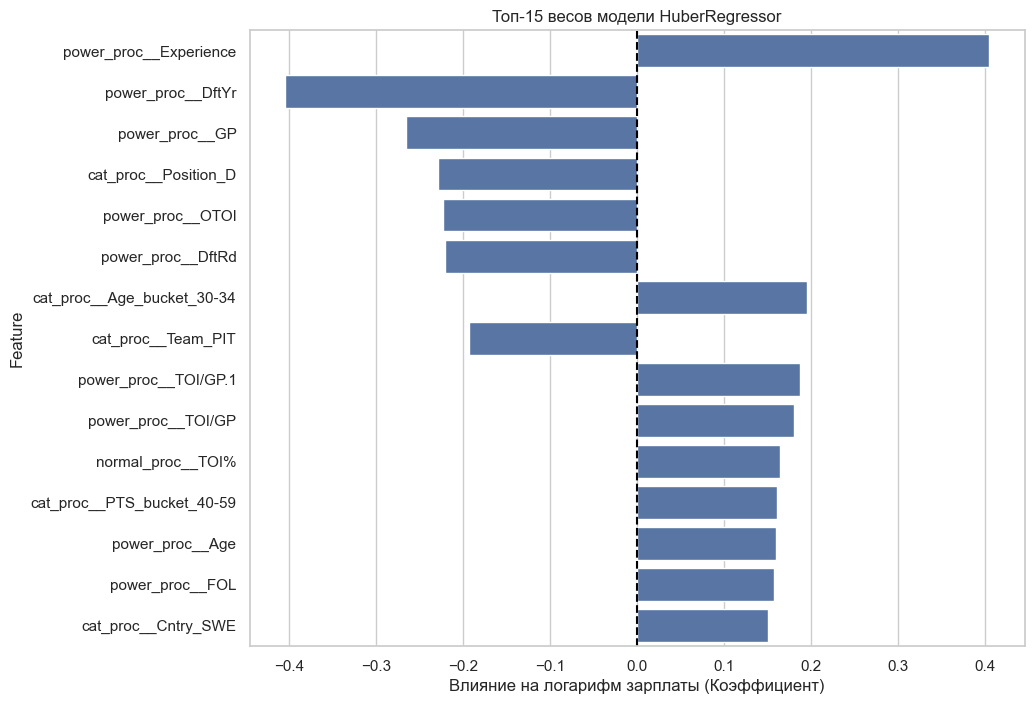

In [646]:
import pandas as pd
import numpy as np

def best_feature(s_grid):
    best_pipe = s_grid.best_estimator_

    preprocessor = best_pipe[0]
    feature_names = preprocessor.get_feature_names_out()

    model_wrapper = best_pipe[-1]
    regressor = model_wrapper.regressor_
    coefficients = regressor.coef_

    df_importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coefficients,
        'Abs_Coefficient': np.abs(coefficients)
    })

    df_importance = df_importance.sort_values(by='Abs_Coefficient', ascending=False)

    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 8))
    sns.barplot(data=df_importance.head(15), x='Coefficient', y='Feature')
    plt.title("Топ-15 весов модели HuberRegressor")
    plt.xlabel("Влияние на логарифм зарплаты (Коэффициент)")
    plt.axvline(0, color='black', linestyle='--')
    plt.show()

best_feature(grid)

По коэфициентам модели видно, что модель делает вполне логичные выводы. На зарплату сильно влияют опыт игрока в лиге, год драфта (молодой игрок получает явно меньше, чем опытный), защитники и игроки из поздних раундов обычно получают меньше, а вот игроки в праймовом возрасте 30-35 больше

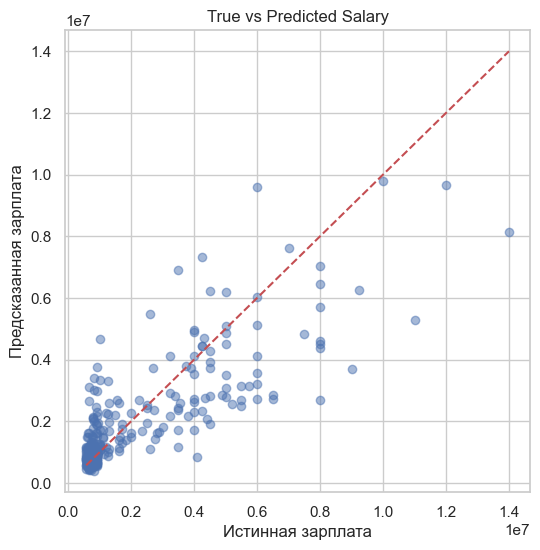

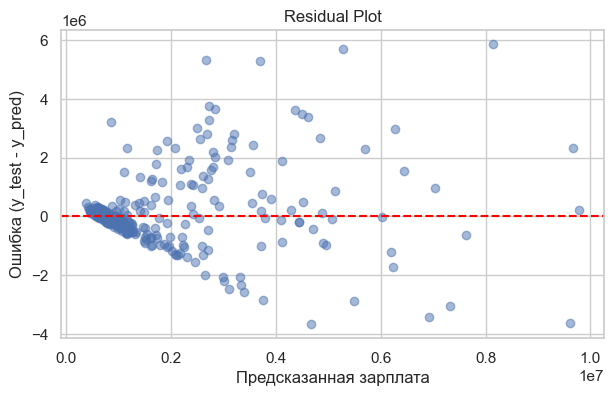

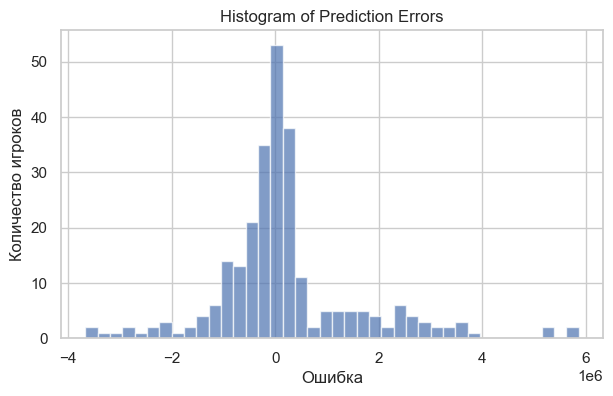

In [647]:
true_vs_predicted(y_test_i, y_pred)
resudial(y_test_i, y_pred)
histogramm_error(y_test_i, y_pred)

Данные стали сильно более кучнее относительно идеальной оси. Это хорошо. Плохо то, что модель всё еще плохо справляется с "выбросами" по зарплате. Если у игрока она очень большая относительно массы, модели сложно определить реальную стоимость и она в основном занижает ее.

In [648]:
original_float_format = pd.get_option('display.float_format')

pd.set_option('display.float_format', '{:.2f}'.format)

best_model = grid.best_estimator_

y_full_pred = best_model.predict(X_i)

results_df = pd.DataFrame({
    'True_Salary': y_i,
    'Predicted_Salary': y_full_pred
})

results_df['Absolute_Error'] = np.abs(results_df['True_Salary'] - results_df['Predicted_Salary'])

test_indices = X_test_i.index
final_results = pd.merge(
    df[['First Name', 'Last Name']],
    results_df,
    left_index=True,
    right_index=True
)

final_results_sorted = final_results.sort_values(by='Absolute_Error', ascending=False)

print("\n--- Топ-10 игроков с наибольшей ошибкой (Train & Test) ---")
print(final_results_sorted.head(10).to_string())

pd.set_option('display.float_format', original_float_format)


--- Топ-10 игроков с наибольшей ошибкой (Train & Test) ---
    First Name Last Name  True_Salary  Predicted_Salary  Absolute_Error
103    Patrick      Kane  13800000.00        5742913.78      8057086.22
817     Steven   Stamkos   9500000.00        2232256.27      7267743.73
496   Jonathan     Toews  13800000.00        7256132.79      6543867.21
626       Anze   Kopitar  14000000.00        8138043.27      5861956.73
830    Patrick     Eaves   1000000.00        6832397.54      5832397.54
208       P.K.    Subban  11000000.00        5287764.15      5712235.85
787      Derek    Stepan   8000000.00        2675662.96      5324337.04
168       Phil    Kessel   9000000.00        3695498.54      5304501.46
594     Evgeni    Malkin   9500000.00        4268385.15      5231614.85
669      Brent     Burns   5760000.00       10355228.22      4595228.22


Кэйн и Стэмкос подписывали контракт с рынка в статусе НСА, поэтому их зарплаты довольно высокие. Что мы тут и видим.

In [649]:
import pandas as pd
final_results['Signed_Error'] = final_results['Predicted_Salary'] - final_results['True_Salary']

overestimated_players = final_results[final_results['Signed_Error'] > 0].copy()

top_overestimated = overestimated_players.sort_values(by='Signed_Error', ascending=False)

print("\n--- Топ-10 игроков с наибольшей переоценкой зарплаты (Predicted > True) ---")

print(top_overestimated[['First Name', 'Last Name',
                         'True_Salary', 'Predicted_Salary', 'Signed_Error']].head(10).to_string())


--- Топ-10 игроков с наибольшей переоценкой зарплаты (Predicted > True) ---
    First Name     Last Name  True_Salary  Predicted_Salary  Signed_Error
830    Patrick         Eaves   1000000.00        6832397.54    5832397.54
669      Brent         Burns   5760000.00       10355228.22    4595228.22
131    Jaromir          Jagr   4000000.00        7806037.99    3806037.99
532      Radim        Vrbata   1000000.00        4669160.62    3669160.62
299     Duncan         Keith   6000000.00        9612676.94    3612676.94
326     Martin        Hanzal   3500000.00        6921397.49    3421397.49
472   Jonathan  Marchessault    750000.00        3984543.57    3234543.57
286     Victor        Hedman   4250000.00        7313924.65    3063924.65
440     Thomas         Vanek   2600000.00        5492364.58    2892364.58
382       Jack        Eichel    925000.00        3758430.96    2833430.96


Тут мы видим всех тех же молодых будущих звёзд лиги, а также ветерана Ягра, который даже в свои очень большие годы всё еще отлично смотрелся. А также очень хорошего защитника Бёрнса.

### My implementation

Напишем теперь свою линейную регрессию. Я решил реализовать Ridge.

In [650]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin

class MyRidge(BaseEstimator, RegressorMixin):
    def __init__(self, alpha=1.0, fit_intercept=True):
        self.alpha = alpha
        self.fit_intercept = fit_intercept

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y).reshape(-1)

        if self.fit_intercept:
            X = np.column_stack([np.ones(X.shape[0]), X])

        XTX = X.T @ X

        I = np.eye(XTX.shape[0])
        if self.fit_intercept:
            I[0, 0] = 0

        XTy = X.T @ y

        self.coef_ = np.linalg.pinv(XTX + self.alpha * I) @ XTy

        return self

    def predict(self, X):
        X = np.asarray(X)

        if self.fit_intercept:
            X = np.column_stack([np.ones(X.shape[0]), X])

        return X @ self.coef_

In [651]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns

model = MyRidge()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
base_mean_error = mean_absolute_error(y_test, [y_train.mean()]*len(y_test))

print(f"--- Baseline LinearRegreesion ---")
print(f"MAE (Ошибка в долларах): {mae:.3f}")
print(f"R2 Score: {r2:.3f}")

--- Baseline LinearRegreesion ---
MAE (Ошибка в долларах): 1320465.400
R2 Score: 0.388


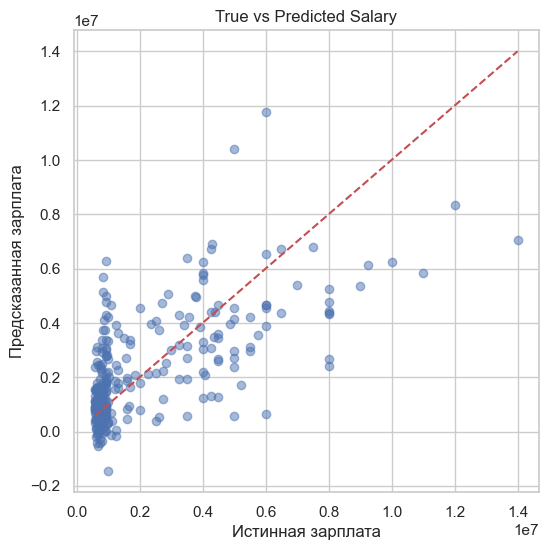

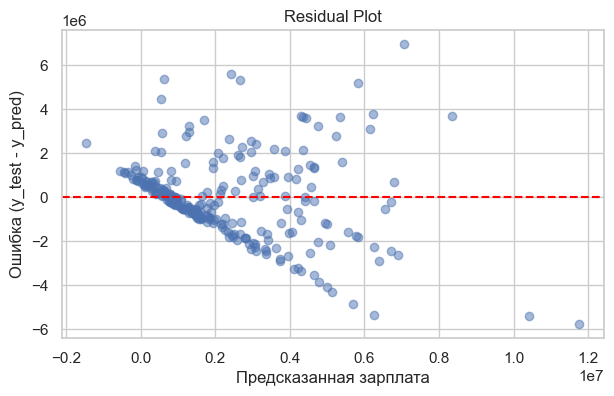

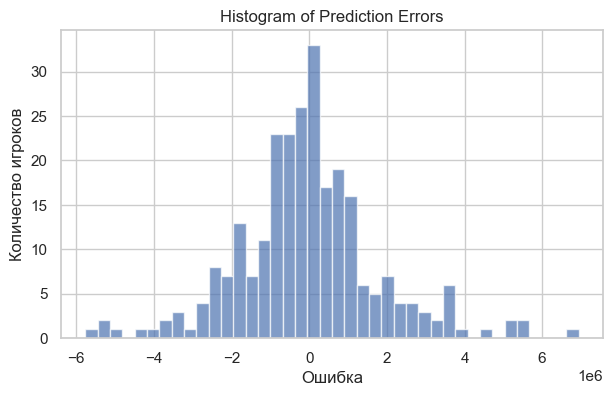

In [652]:
true_vs_predicted(y_test, y_pred)
resudial(y_test, y_pred)
histogramm_error(y_test, y_pred)

In [653]:
full_pipeline = Pipeline([
    ('preprocessor', ct),
    ('model_wrapper', TransformedTargetRegressor(
        regressor=MyRidge(),
        func=np.log1p,
        inverse_func=np.expm1
    ))
])

param_grid = {
    'preprocessor__normal_proc__scaler': [
        RobustScaler(),
        PowerTransformer(),
        QuantileTransformer(n_quantiles=400)
    ],
    'preprocessor__power_proc__scaler': [
        StandardScaler(),
        PowerTransformer(),
        QuantileTransformer(n_quantiles=400)
    ],
    'model_wrapper__regressor__alpha': [0.1, 1.0, 10.0, 50.0]
}

grid = GridSearchCV(
    full_pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_i, y_train_i)

print(grid.best_params_)

y_pred = grid.best_estimator_.predict(X_test_i)

mae = mean_absolute_error(y_test_i, y_pred)
r2 = r2_score(y_test_i, y_pred)

print(f"\n--- Ridge Regression ---")
print(f"MAE: {mae:.3f}")
print(f"R2 Score: {r2:.3f}")
print(f"MAE для baseline (среднее): {base_mean_error:.3f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
{'model_wrapper__regressor__alpha': 10.0, 'preprocessor__normal_proc__scaler': RobustScaler(), 'preprocessor__power_proc__scaler': QuantileTransformer(n_quantiles=400)}

--- Ridge Regression ---
MAE: 895660.583
R2 Score: 0.620
MAE для baseline (среднее): 1877717.767


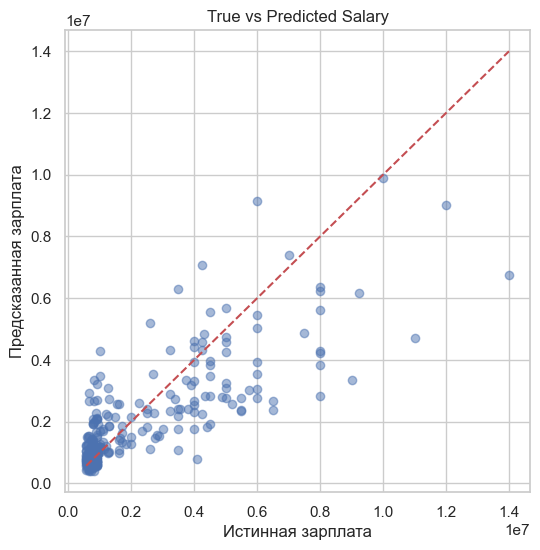

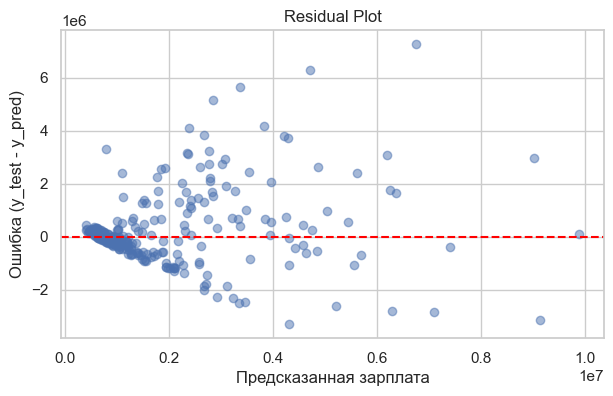

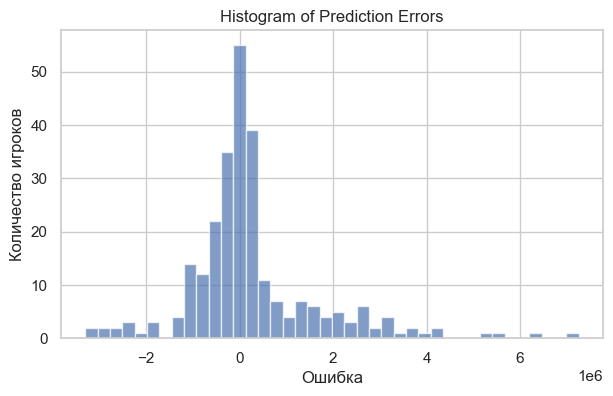

In [654]:
true_vs_predicted(y_test_i, y_pred)
resudial(y_test_i, y_pred)
histogramm_error(y_test_i, y_pred)

Собственная модель с регуляризацией работает неплохо, чуть хуже чем Huber, потому что хуже работает с выбросами.

|     | Base Linear Regression | Huber Regression | My Ridge   |
|-----|------------------------|------------------|------------|
| R2  | 0.324                  | 0.644            | 0.620      |
| MAE | 1381895.059            | 876739.311       | 895660.583 |

## Классификация
Задача: вычислить мошенника на страховых выплатах с использованием моделей линейной регрессии

Для выполнения лабораторной работы были выбраны метрики F1-score и ROC-AUC, так как исследуемый датасет является несбалансированным. Метрика Accuracy в данном случае неинформативна, так как модель, предсказывающая всем класс ‘0’ (не фрод), может иметь высокую Accuracy, но будет бесполезна. F1-score позволит контролировать баланс между ложными срабатываниями и пропуском мошенников.

### Baseline

In [655]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
                                  "buntyshah/auto-insurance-claims-data/versions/1",
                                  "insurance_claims.csv")
df

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NaN
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,?,5070,780,780,3510,Mercedes,E400,2007,Y,NaN
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NaN
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,NO,6500,1300,650,4550,Accura,RSX,2009,N,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,1991-07-16,OH,500/1000,1000,1310.80,0,431289,...,?,87200,17440,8720,61040,Honda,Accord,2006,N,NaN
996,285,41,186934,2014-01-05,IL,100/300,1000,1436.79,0,608177,...,?,108480,18080,18080,72320,Volkswagen,Passat,2015,N,NaN
997,130,34,918516,2003-02-17,OH,250/500,500,1383.49,3000000,442797,...,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N,NaN
998,458,62,533940,2011-11-18,IL,500/1000,2000,1356.92,5000000,441714,...,YES,46980,5220,5220,36540,Audi,A5,1998,N,NaN


In [656]:
df_clean = df.copy()

TARGET_NAME = "fraud_reported"
df_clean["fraud_reported"] = df_clean["fraud_reported"].map({'Y': 1, 'N': 0})
df_clean["police_report_available"] = df_clean["police_report_available"].map({'YES': 1, 'NO': 0}).fillna(-1)
df_clean["property_damage"] = df_clean["police_report_available"].map({'YES': 1, 'NO': 0}).fillna(-1)

In [657]:
for col in df_clean.select_dtypes(include=['object']).columns:
    df_clean[col] = df_clean[col].astype('category').cat.codes
df_clean.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48,521585,940,2,1,1000,1406.91,0,466132,...,1.00,71610,6510,13020,52080,10,1,2004,1,NaN
1,228,42,342868,635,1,1,2000,1197.22,5000000,468176,...,-1.00,5070,780,780,3510,8,12,2007,1,NaN
2,134,29,687698,413,2,0,2000,1413.14,5000000,430632,...,0.00,34650,7700,3850,23100,4,30,2007,0,NaN
3,256,41,227811,19,0,1,2000,1415.74,6000000,608117,...,0.00,63400,6340,6340,50720,3,34,2014,1,NaN
4,228,44,367455,922,0,2,1000,1583.91,6000000,610706,...,0.00,6500,1300,650,4550,0,31,2009,0,NaN


In [658]:
df_clean = df_clean.fillna(0)

In [659]:
from sklearn.model_selection import train_test_split
drop_dates = ["policy_bind_date", "incident_date"]
df_clean = df_clean.drop(drop_dates, axis=1)
X = df_clean.drop(TARGET_NAME, axis=1)
y = df_clean[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [660]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix, roc_curve

model = LogisticRegression(max_iter=800)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

results = {'F1-score': f1, 'ROC-AUC': roc}

print(f"F1-score (класс 1): {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("="*50)

F1-score (класс 1): 0.0000
ROC-AUC: 0.6118
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       226
           1       0.00      0.00      0.00        74

    accuracy                           0.75       300
   macro avg       0.38      0.50      0.43       300
weighted avg       0.57      0.75      0.65       300



/Users/zloyaloha/development/ai-frameworks/.venv_ai/lib/python3.14/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 800 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=800).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


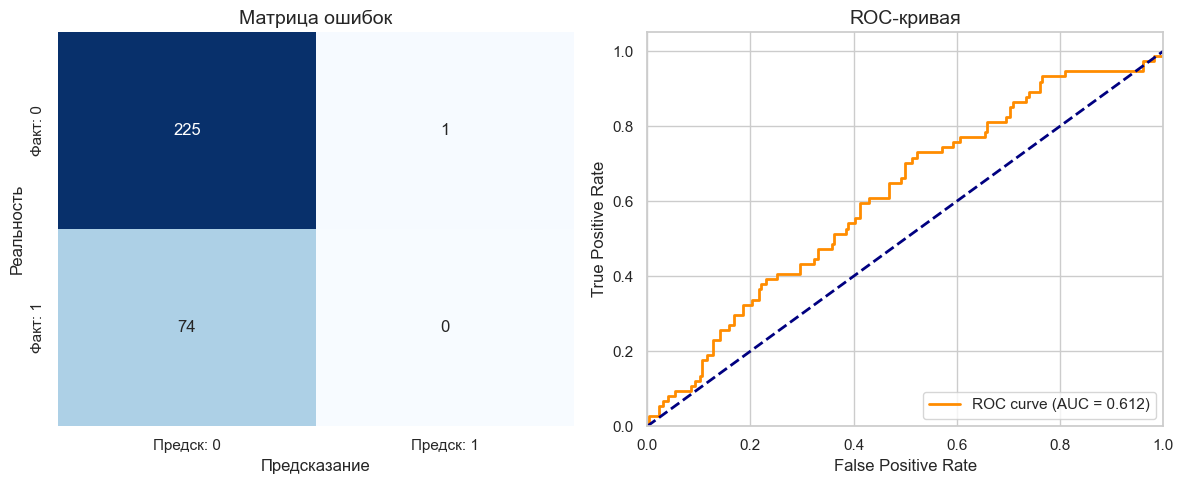

In [661]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
def graphics(y_test, y_pred, y_prob):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False,
                xticklabels=['Предск: 0', 'Предск: 1'],
                yticklabels=['Факт: 0', 'Факт: 1'])
    plt.title("Матрица ошибок", fontsize=14)
    plt.ylabel("Реальность")
    plt.xlabel("Предсказание")

    plt.subplot(1, 2, 2)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая', fontsize=14)
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()
graphics(y_test, y_pred, y_prob)


Базовая логистическая регрессия совсем не хочет искать мошенников. Ей проще записать всех в честных и в целом, она даже будет права xD

### Improved Logistic Regressor

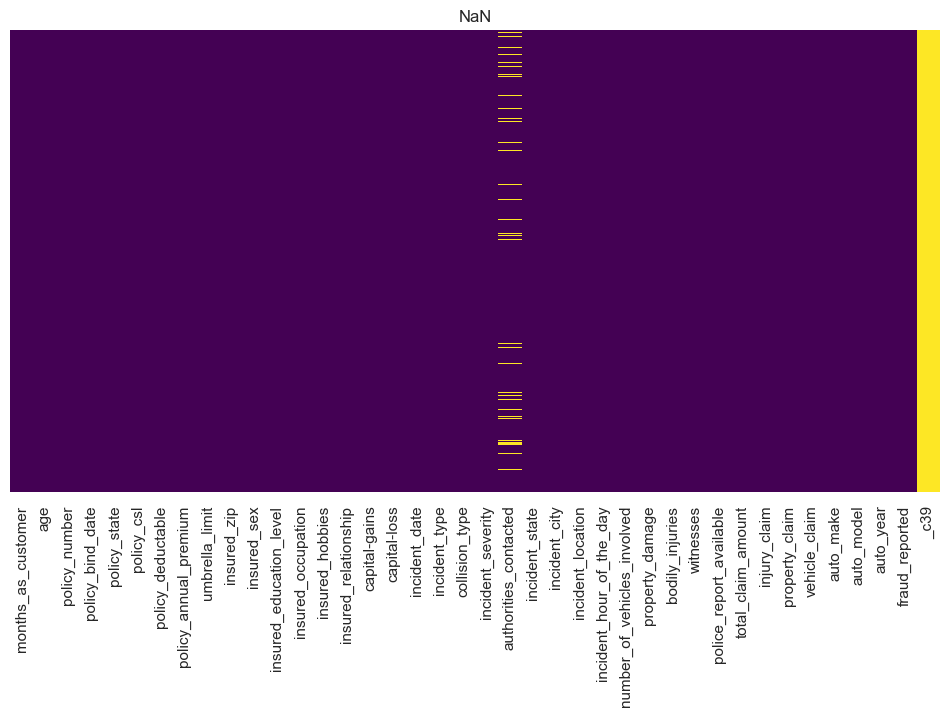

In [662]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS,
                                  "buntyshah/auto-insurance-claims-data/versions/1",
                                  "insurance_claims.csv")
df.head()

nulls = df.isna().sum().sort_values(ascending=False)
null_pct = (nulls / len(df)).mul(100).round(2)

plt.figure(figsize=(12,6))
sns.heatmap(df.isna(), cbar=False, yticklabels=False, cmap="viridis")
plt.title("NaN")
plt.show()

In [663]:
df_clean = df.copy()
df_clean = df_clean.drop(columns=["_c39"])
df_clean["authorities_contacted"] = df_clean["authorities_contacted"].fillna("No Contact")

In [664]:
TARGET_NAME = "fraud_reported"
df_clean[TARGET_NAME].value_counts()

fraud_reported
N    753
Y    247
Name: count, dtype: int64

In [665]:
display(df_clean["police_report_available"].unique())
display(df_clean["property_damage"].unique())

array(['YES', '?', 'NO'], dtype=object)

array(['YES', '?', 'NO'], dtype=object)

In [666]:
import pandas as pd

df_clean["fraud_reported"] = df_clean["fraud_reported"].map({'Y': 1, 'N': 0})
df_clean["police_report_available"] = df_clean["police_report_available"].map({'YES': 1, 'NO': 0, '?': -1})
df_clean["property_damage"] = df_clean["property_damage"].map({'YES': 1, 'NO': 0, '?': -1})

In [667]:
dates_cols = ["policy_bind_date", "incident_date"]
for c in dates_cols:
    df_clean[c] = pd.to_datetime(df_clean[c])
df_clean

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,...,2,1,71610,6510,13020,52080,Saab,92x,2004,1
1,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,...,0,-1,5070,780,780,3510,Mercedes,E400,2007,1
2,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,...,3,0,34650,7700,3850,23100,Dodge,RAM,2007,0
3,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,...,2,0,63400,6340,6340,50720,Chevrolet,Tahoe,2014,1
4,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,...,1,0,6500,1300,650,4550,Accura,RSX,2009,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3,38,941851,1991-07-16,OH,500/1000,1000,1310.80,0,431289,...,1,-1,87200,17440,8720,61040,Honda,Accord,2006,0
996,285,41,186934,2014-01-05,IL,100/300,1000,1436.79,0,608177,...,3,-1,108480,18080,18080,72320,Volkswagen,Passat,2015,0
997,130,34,918516,2003-02-17,OH,250/500,500,1383.49,3000000,442797,...,3,1,67500,7500,7500,52500,Suburu,Impreza,1996,0
998,458,62,533940,2011-11-18,IL,500/1000,2000,1356.92,5000000,441714,...,1,1,46980,5220,5220,36540,Audi,A5,1998,0


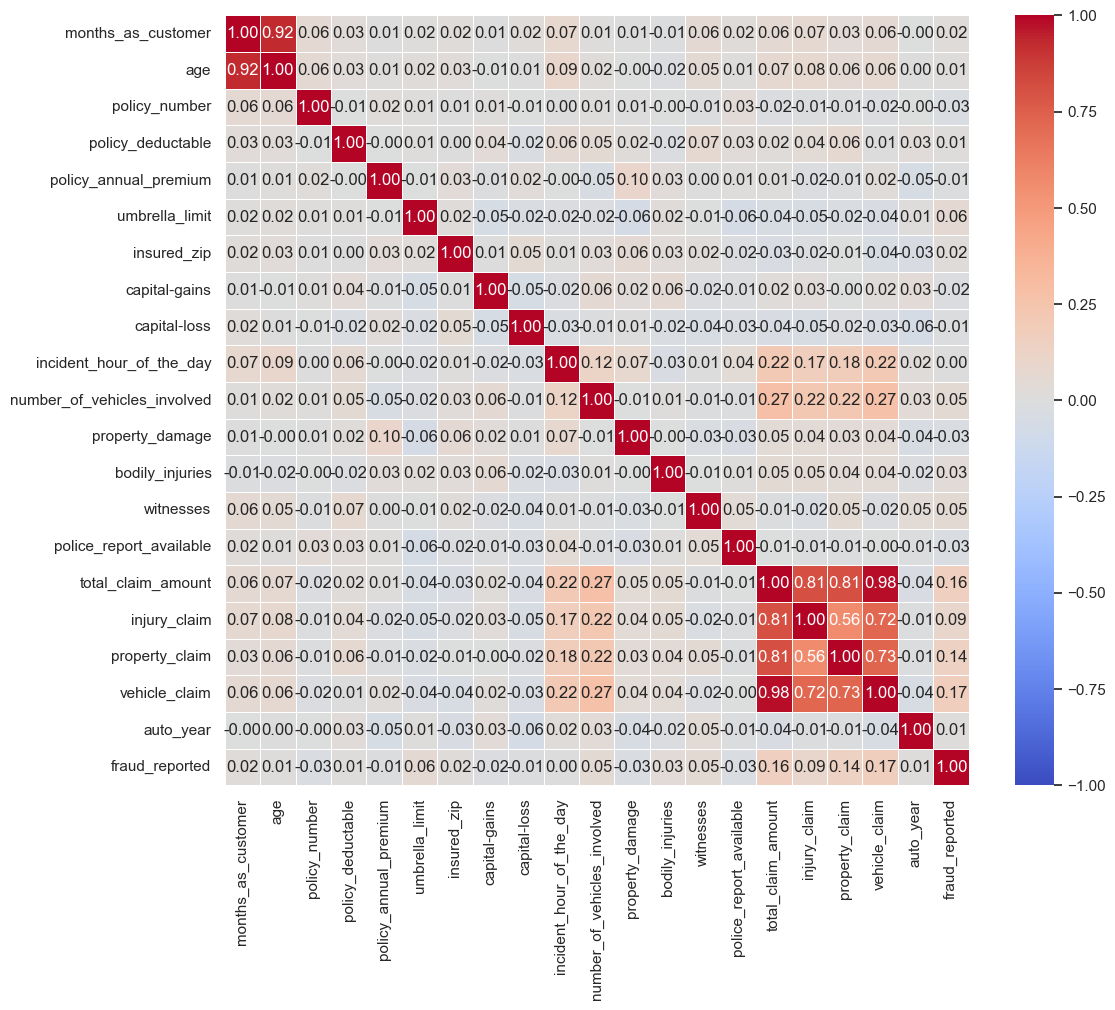

In [668]:
num_cols = df_clean.select_dtypes(include=["int64", "float64"]).columns.tolist()

plt.figure(figsize=(12, 10))
correlation_matrix = df_clean[num_cols].corr()

sns.heatmap(correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            vmin=-1, vmax=1,
            linewidths=0.5)

plt.show()

In [669]:
num_cols = df_clean.select_dtypes(include=["int64", "float64"]).columns.tolist()
df_clean[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
months_as_customer,1000.00,203.95,115.11,0.00,115.75,199.50,276.25,479.00
age,1000.00,38.95,9.14,19.00,32.00,38.00,44.00,64.00
policy_number,1000.00,546238.65,257063.01,100804.00,335980.25,533135.00,759099.75,999435.00
policy_deductable,1000.00,1136.00,611.86,500.00,500.00,1000.00,2000.00,2000.00
policy_annual_premium,1000.00,1256.41,244.17,433.33,1089.61,1257.20,1415.70,2047.59
umbrella_limit,1000.00,1101000.00,2297406.60,-1000000.00,0.00,0.00,0.00,10000000.00
insured_zip,1000.00,501214.49,71701.61,430104.00,448404.50,466445.50,603251.00,620962.00
capital-gains,1000.00,25126.10,27872.19,0.00,0.00,0.00,51025.00,100500.00
capital-loss,1000.00,-26793.70,28104.10,-111100.00,-51500.00,-23250.00,0.00,0.00
incident_hour_of_the_day,1000.00,11.64,6.95,0.00,6.00,12.00,17.00,23.00


In [670]:
import numpy as np

df_pr = df_clean.copy()

median_value = df_pr.loc[df_pr['umbrella_limit'] != -100000, 'umbrella_limit'].median()
df_pr.loc[df_pr['umbrella_limit'] == -100000, 'umbrella_limit'] = median_value

In [671]:
df_features = df_pr.copy()

df_features["age_bucket"] = pd.cut(
    df_features["age"],
    bins=[0, 25, 35, 45, 55, 65, 100],
    labels=["<25", "25-34", "35-44", "45-54", "55-64", "65+"],
)

df_features["incident_year"] = df_features["incident_date"].dt.year
df_features["incident_month"] = df_features["incident_date"].dt.month
df_features["incident_dow"] = df_features["incident_date"].dt.dayofweek

df_features["injury_ratio"] = df_features["injury_claim"] / (df_features["total_claim_amount"] + 1e-3)
df_features["property_ratio"] = df_features["property_claim"]  / (df_features["total_claim_amount"] + 1e-3)
df_features["vehicle_ratio"] = df_features["vehicle_claim"] / (df_features["total_claim_amount"] + 1e-3)

drop_dates = ["policy_bind_date", "incident_date"]
df_features = df_features.drop(drop_dates, axis=1)

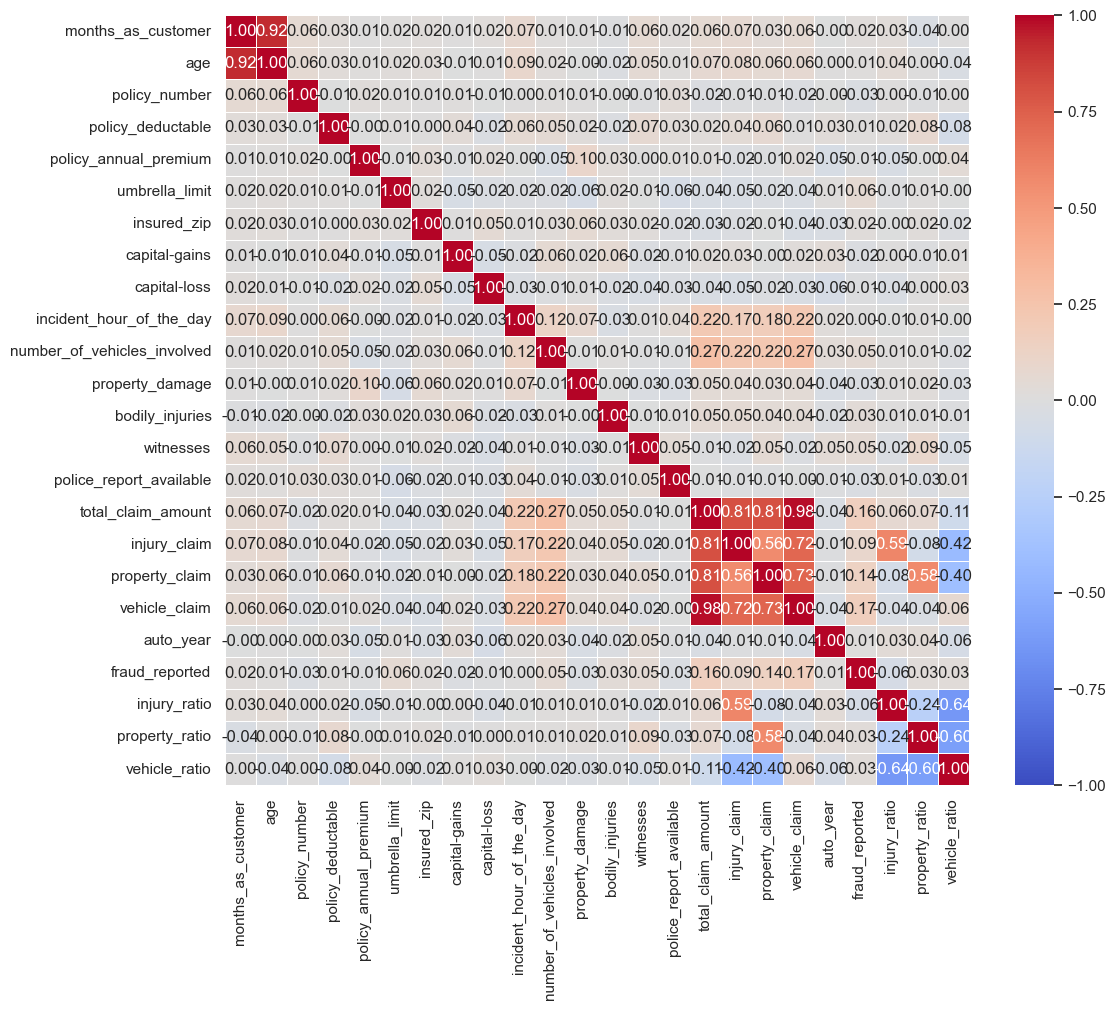

In [672]:
num_cols = df_features.select_dtypes(include=["int64", "float64"]).columns.tolist()

plt.figure(figsize=(12, 10))
correlation_matrix = df_features[num_cols].corr()

sns.heatmap(correlation_matrix,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            vmin=-1, vmax=1,
            linewidths=0.5)

plt.show()

In [673]:
from sklearn.model_selection import train_test_split
X_i = df_features.drop(TARGET_NAME, axis=1)
y_i = df_features[TARGET_NAME]
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X_i, y_i, test_size=0.25, random_state=42, stratify=y_i)

Тут тоже фактически изменения только в модели. Я использовал liblinear solver в сетку добавил l1, l2 регуляризацию. Перестал использовать SMOTE, поскольку логистический классификатор нативно работает с несбалансированными классами.

In [674]:
from category_encoders import WOEEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import QuantileTransformer

num_cols = X_i.select_dtypes(["int64", "float64"]).columns.tolist()
cat_cols = X_i.select_dtypes(["object", "category"]).columns.tolist()

numeric_pipe     = Pipeline([("scale", QuantileTransformer(n_quantiles=400))])
categorical_pipe = Pipeline([("onehot", WOEEncoder())])


ct  = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

model_pipe = Pipeline([
    ('ct', ct),
    ('model', LogisticRegression(solver='liblinear', max_iter=5000, random_state=42))
])

param_grid = {
    'model__C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
    'model__penalty': ['l1', 'l2'],
    'model__class_weight': [None, 'balanced'],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    model_pipe,
    param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_i, y_train_i)

print(grid.best_params_)

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test_i)
y_prob = best_model.predict_proba(X_test_i)[:, 1]

f1 = f1_score(y_test_i, y_pred)
roc = roc_auc_score(y_test_i, y_prob)

results = {'F1-score': f1, 'ROC-AUC': roc}

print(f"F1-score (класс 1): {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test_i, y_pred))
print("="*50)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'model__C': 0.1, 'model__class_weight': None, 'model__penalty': 'l1'}
F1-score (класс 1): 0.6230
ROC-AUC: 0.8513
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       188
           1       0.63      0.61      0.62        62

    accuracy                           0.82       250
   macro avg       0.75      0.75      0.75       250
weighted avg       0.81      0.82      0.81       250



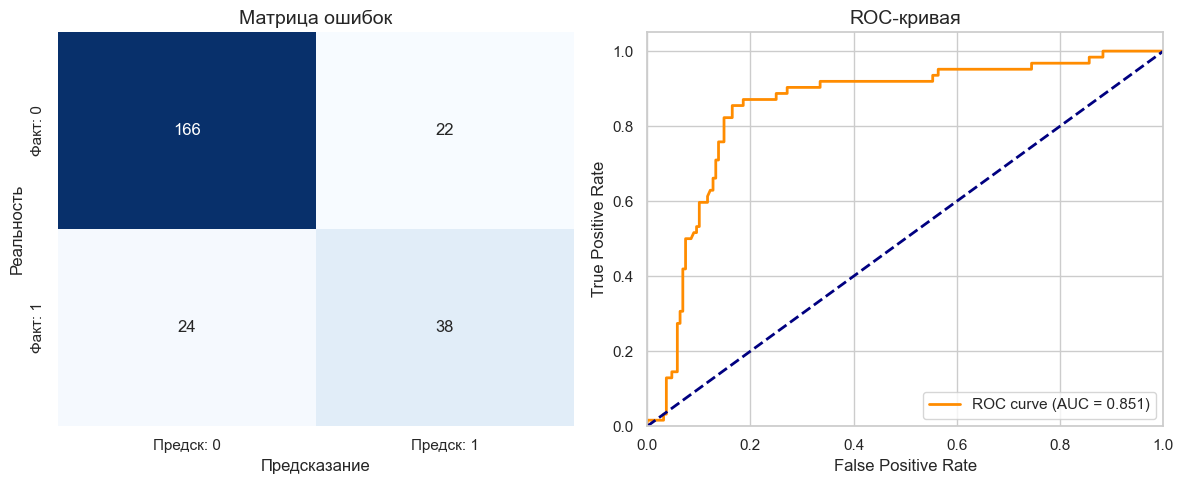

In [675]:
graphics(y_test_i, y_pred, y_prob)

В результате получилось чуть хуже, чем улучшенный KNN. Эта модель нашла меньше мошенников, но при этом и меньше неверно указала на честных людей. Лучше конечно в реальной жизни использовать KNN, потому что лучше лишний раз проверить честного, чем пропустить мошенника. Это дешевле

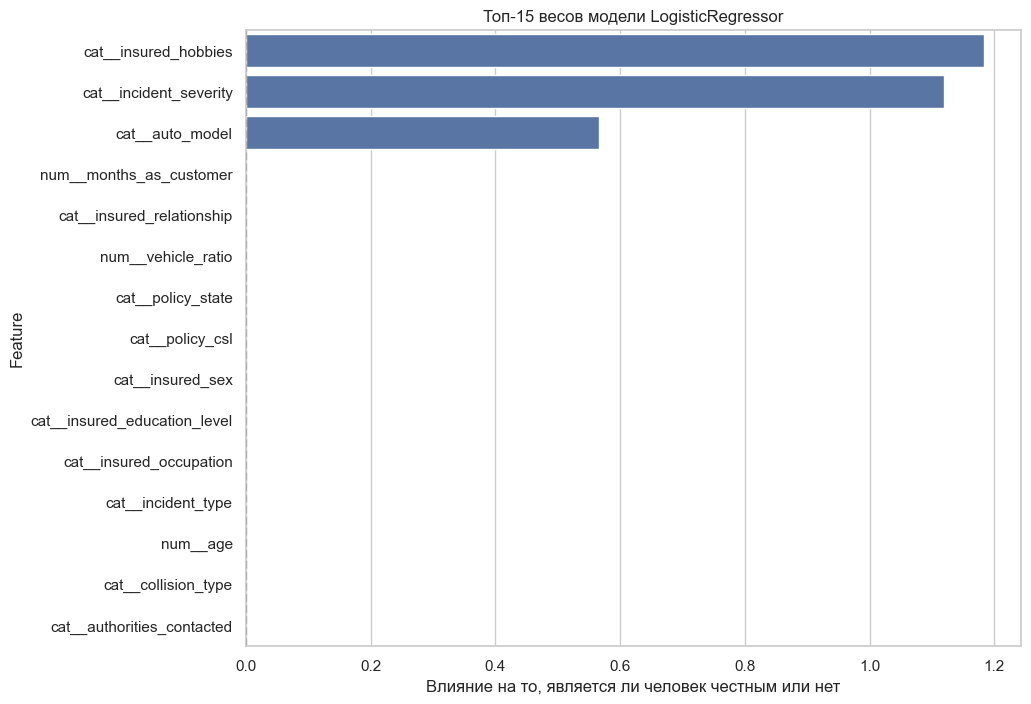

In [676]:
import pandas as pd
import numpy as np

best_pipe = grid.best_estimator_

feature_names = best_pipe.named_steps['ct'].get_feature_names_out()

model = best_pipe.named_steps['model']

coefficients = model.coef_.flatten()

df_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
})

df_importance = df_importance.sort_values(by='Abs_Coefficient', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=df_importance.head(15), x='Coefficient', y='Feature')
plt.title("Топ-15 весов модели LogisticRegressor")
plt.xlabel("Влияние на то, является ли человек честным или нет")
plt.axvline(0, color='black', linestyle='--')
plt.show()

Модель посчитала, что самыми важными признаками является хобби, серъезность повреждений и модель автомобиля. В целом это сочитается с реальностью.

### My implementation

In [677]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted, check_array
from sklearn.utils.multiclass import unique_labels

class MyLogisticRegression(ClassifierMixin, BaseEstimator):
    def __init__(self, learning_rate=0.01, n_iters=1000, threshold=0.5,
                 reg_strength=0.0, class_weight=None):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.threshold = threshold
        self.reg_strength = reg_strength
        self.class_weight = class_weight
        self.weights = None
        self.bias = None

    def _sigmoid(self, z):
        z = np.clip(z, -250, 250)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        sample_weights = np.ones(n_samples)
        if self.class_weight == 'balanced':
            n_pos = np.sum(y == 1)
            n_neg = np.sum(y == 0)
            weight_pos = n_samples / (2 * n_pos) if n_pos > 0 else 1.0
            weight_neg = n_samples / (2 * n_neg) if n_neg > 0 else 1.0
            sample_weights = np.where(y == 1, weight_pos, weight_neg)

        for _ in range(self.n_iters):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self._sigmoid(linear_model)
            error = y_predicted - y
            weighted_error = error * sample_weights
            dw = (1 / n_samples) * np.dot(X.T, weighted_error)
            db = (1 / n_samples) * np.sum(weighted_error)
            if self.reg_strength > 0:
                dw += (self.reg_strength / n_samples) * self.weights
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db
        return self

    def predict_proba(self, X):
        check_is_fitted(self)
        X = check_array(X)
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)
        return np.vstack(((1 - y_predicted), y_predicted)).T

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self._sigmoid(linear_model)
        return np.array([1 if i > self.threshold else 0 for i in y_predicted])

In [678]:
model = MyLogisticRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)

results = {'F1-score': f1, 'ROC-AUC': roc}

print(f"F1-score (класс 1): {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("="*50)

F1-score (класс 1): 0.0000
ROC-AUC: 0.5000
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       226
           1       0.00      0.00      0.00        74

    accuracy                           0.75       300
   macro avg       0.38      0.50      0.43       300
weighted avg       0.57      0.75      0.65       300



/Users/zloyaloha/development/ai-frameworks/.venv_ai/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/zloyaloha/development/ai-frameworks/.venv_ai/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/zloyaloha/development/ai-frameworks/.venv_ai/lib/python3.14/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this b

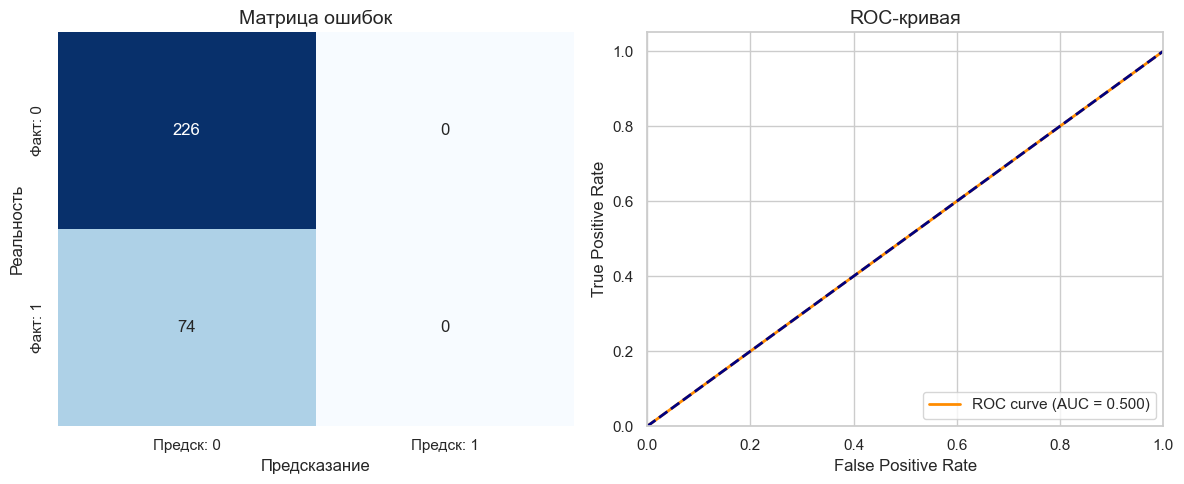

In [679]:
graphics(y_test, y_pred, y_prob)

In [680]:
model_pipe = Pipeline([
    ('ct', ct),
    ('model', MyLogisticRegression(class_weight='balanced'))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'model__learning_rate': [0.01, 0.1, 0.5],
    'model__n_iters': [2000],
    'model__reg_strength': [0.0, 0.1, 1.0, 10.0]
}

grid = GridSearchCV(
    model_pipe,
    param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_i, y_train_i)
print(grid.best_params_)

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test_i)
y_prob = best_model.predict_proba(X_test_i)[:, 1]

f1 = f1_score(y_test_i, y_pred)
roc = roc_auc_score(y_test_i, y_prob)

results = {'F1-score': f1, 'ROC-AUC': roc}

print(f"F1-score (класс 1): {f1:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print("-" * 30)
print("Classification Report:")
print(classification_report(y_test_i, y_pred))
print("="*50)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
{'model__learning_rate': 0.01, 'model__n_iters': 2000, 'model__reg_strength': 0.1}
F1-score (класс 1): 0.7092
ROC-AUC: 0.8542
------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       188
           1       0.63      0.81      0.71        62

    accuracy                           0.84       250
   macro avg       0.78      0.83      0.80       250
weighted avg       0.86      0.84      0.84       250



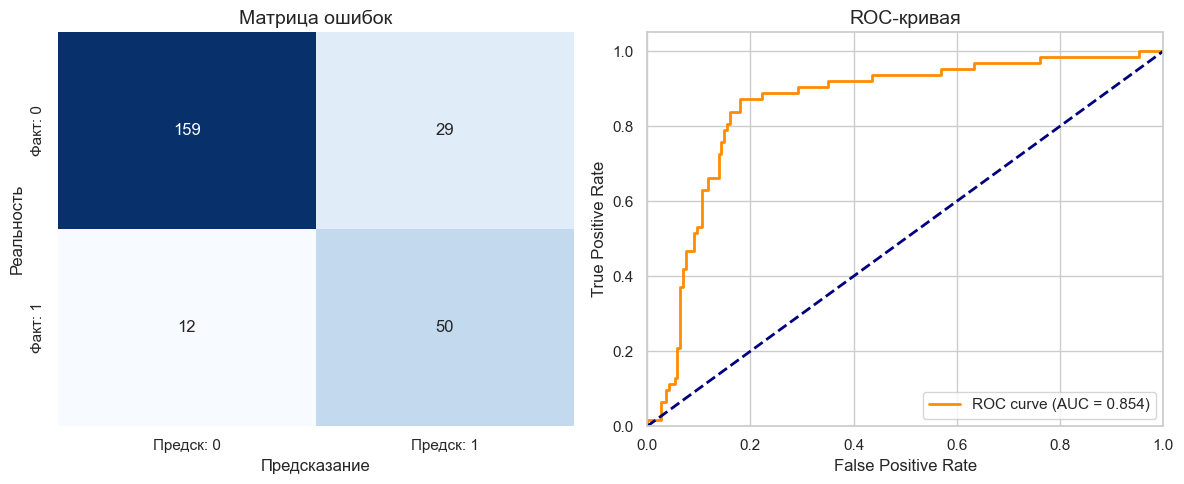

In [681]:
graphics(y_test_i, y_pred, y_prob)

Моя модель использует обычный градиентный спуск, в отличие от решателя от scikit-learn, и она показала лучшие результаты! Моя модель чаще находит мошенников, но при этом чуть чаще ошибается на честных.

|              | Base Linear Classifier | Logistic Classifier | My Logistic Classifier |
|--------------|------------------------|---------------------|------------------------|
| ROC_AUC      | 0.6118                 | 0.8513              | 0.8542                 |
| F1 (1 класс) | 0.86                   | 0.88                | 0.89                   |
| F1 (2 класс) | 0.00                   | 0.62                | 0.71                   |

## Вывод

Линейные алгоритмы дали хороший результат в обоих задачах. Пишутся они легко, интерпретируются также, поэтому я смог вывести фичи, которые модель считает основными для этих задач. Улучшение в задаче регрессии очень значительное, линейной модели легче найти закономерность среди большого количества фичей, чем размывающееся от большого количества расстояние в KNN.